In [1]:
import json, pathlib, pandas as pd
import numpy as np

path = pathlib.Path("/home/neocortex/repos/LLaMEA/exp-07-31_110848-LLaMEA-o4-mini-2025-04-16-ELA/log.jsonl")      # 🔴 update if needed
records = [json.loads(line) for line in path.open()]

df = pd.json_normalize(records)
print(df.columns)

df = df[["fitness", "name", "code", "metadata.score1", "metadata.score2", "metadata.ela_features"]]
df = df.rename(columns={"metadata.score1": "score1", "metadata.score2": "score2", "metadata.ela_features": "ela"})
df.dropna(inplace=True)  # drop rows with NaN values

# -- unwrap [[...]] → [...]
df["ela"] = df["ela"].apply(lambda v: v[0] if isinstance(v, (list, tuple)) and len(v)==1 else v)
print(df["ela"])
# -- explode into separate numeric columns
ela_mat = np.vstack(df["ela"].values)
ela_cols = [f"ela_{i}" for i in range(ela_mat.shape[1])]
ela_df   = pd.DataFrame(ela_mat, columns=ela_cols, index=df.index)

df = pd.concat([df.drop(columns=["ela"]), ela_df], axis=1)

df.head()        # sanity-check


Index(['id', 'fitness', 'name', 'description', 'code', 'configspace',
       'generation', 'feedback', 'error', 'parent_ids', 'operator',
       'metadata.ela_features', 'metadata.score1', 'metadata.score2'],
      dtype='object')
0      [-0.0027136652937160832, 0.41089754856882965, ...
1      [-0.0006234484223048842, 0.45720947114133736, ...
2      [-0.00014673556088196094, 0.35730690032067314,...
3      [-0.00012374982519691713, 0.4278118969819157, ...
4      [-0.002246789953758377, 0.4355076512383817, 3....
                             ...                        
499    [0.0003014209128182621, 0.3292284577367412, 0....
500    [0.5340829750553688, 0.12940257319217208, 0.02...
501    [0.4100832601892861, 0.22220156085581577, 0.08...
502    [0.1634307210508712, 0.24764731712255328, 0.01...
503    [0.45407565155476826, 0.44082534066915763, 0.0...
Name: ela, Length: 481, dtype: object


,fitness,name,code,score1,score2,ela_0,ela_1,ela_2,ela_3,ela_4,...,ela_32,ela_33,ela_34,ela_35,ela_36,ela_37,ela_38,ela_39,ela_40,ela_41
0,0.524907,NovelLandscape,import numpy as np\n\nclass NovelLandscape:\n ...,0.997021,0.052794,-0.002714,0.410898,0.001159,0.014985,12.929684,...,-0.248553,0.833333,1.0,0.200110,0.177483,0.823540,0.105105,0.253749,-0.395395,0.529647
1,0.148197,landscape,import numpy as np\n\nclass landscape:\n de...,0.237673,0.058720,-0.000623,0.457209,0.005742,0.023433,4.080988,...,-0.253439,0.833333,1.0,0.198351,0.181432,0.818067,0.145145,0.231401,-0.355355,0.492788
2,0.668359,CompositeGaussianValley,import numpy as np\n\nclass CompositeGaussianV...,0.993136,0.343582,-0.000147,0.357307,0.001255,0.024688,19.670572,...,-0.245841,0.833333,1.0,0.204280,0.182286,0.818949,0.125125,0.242317,-0.375375,0.517628
3,0.524707,DampedOscillationLandscape,import numpy as np\n\nclass DampedOscillationL...,0.996620,0.052794,-0.000124,0.427812,0.003360,0.027549,8.200236,...,-0.241430,0.833333,1.0,0.204390,0.181635,0.845557,0.085085,0.253749,-0.395395,0.546474
4,0.517228,HybridLandscape,import numpy as np\n\nclass HybridLandscape:\n...,0.999639,0.034817,-0.002247,0.435508,0.000040,0.019540,489.806233,...,-0.238277,0.833333,1.0,0.204918,0.183307,0.843752,0.165165,0.291383,-0.335335,0.548077


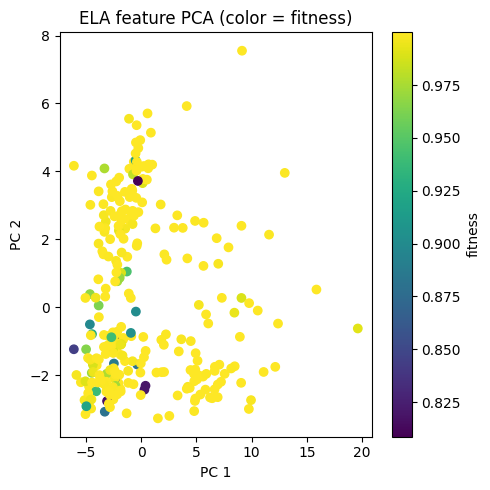

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Filter the best fitness values above 0.8 threshold
df_best = df[df["fitness"] > 0.8]

X_scaled = StandardScaler().fit_transform(df_best[ela_cols])
pc       = PCA(n_components=2).fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(5, 5))
sc      = ax.scatter(pc[:, 0], pc[:, 1], c=df_best["fitness"], cmap="viridis")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("ELA feature PCA (color = fitness)")
plt.colorbar(sc, label="fitness")
plt.tight_layout()


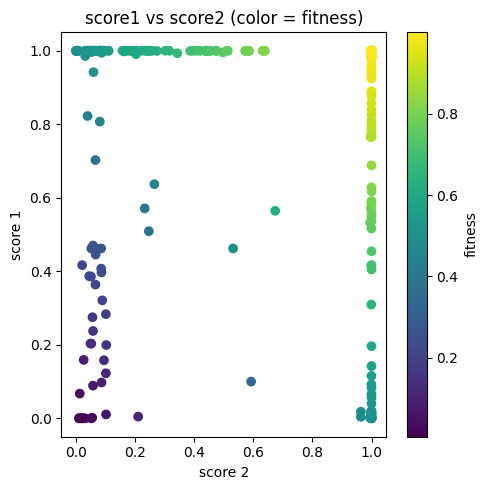

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
sc      = ax.scatter(df["score2"], df["score1"], c=df["fitness"], cmap="viridis")
ax.set_xlabel("score 2")
ax.set_ylabel("score 1")
ax.set_title("score1 vs score2 (color = fitness)")
plt.colorbar(sc, label="fitness")
plt.tight_layout()


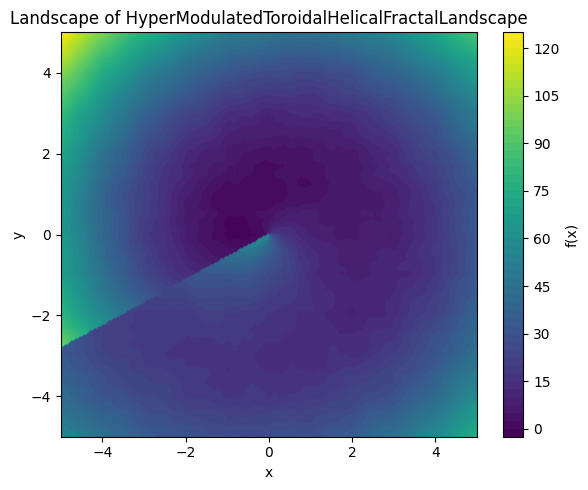

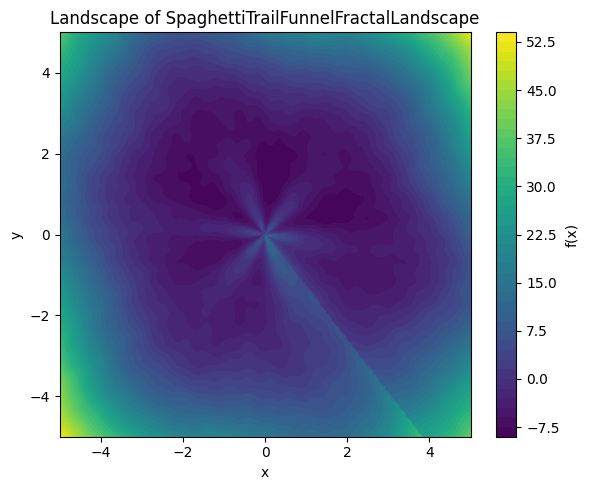

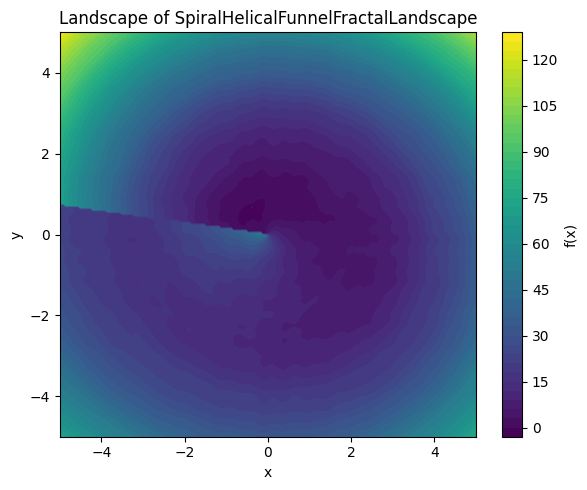

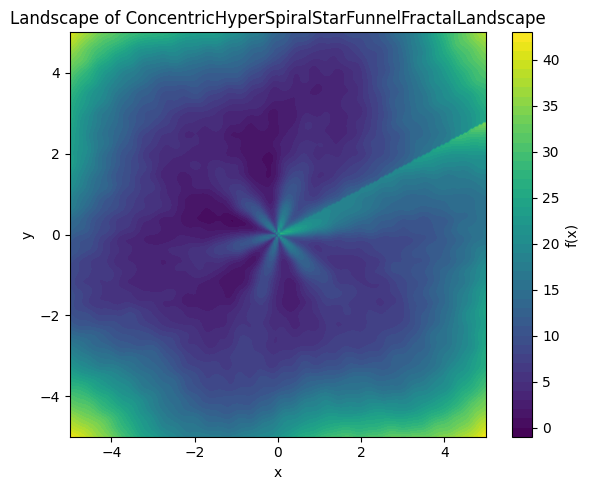

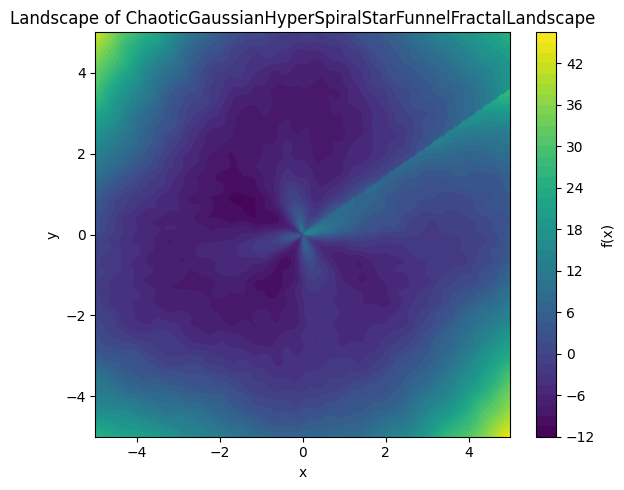

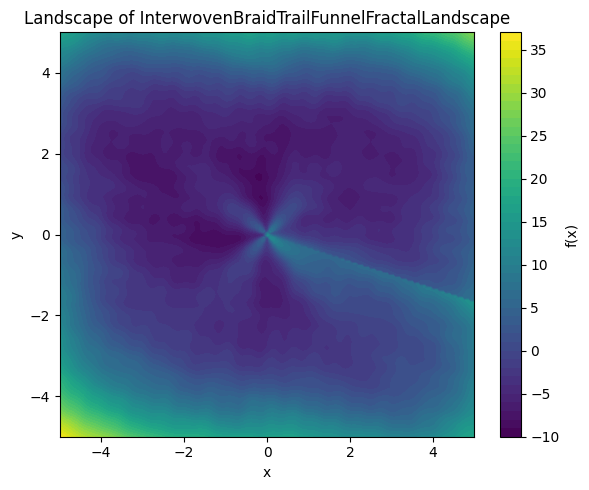

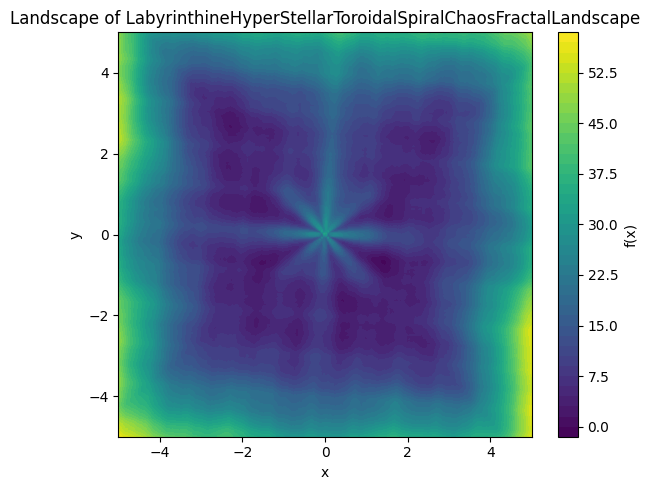

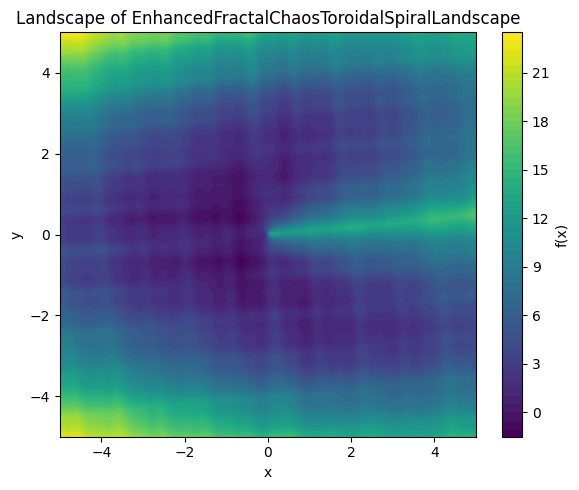

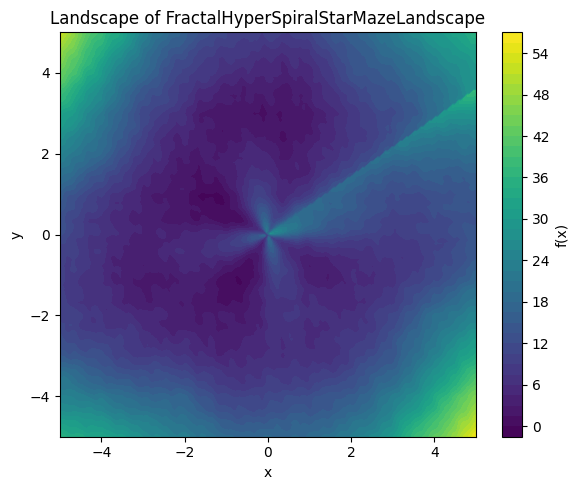

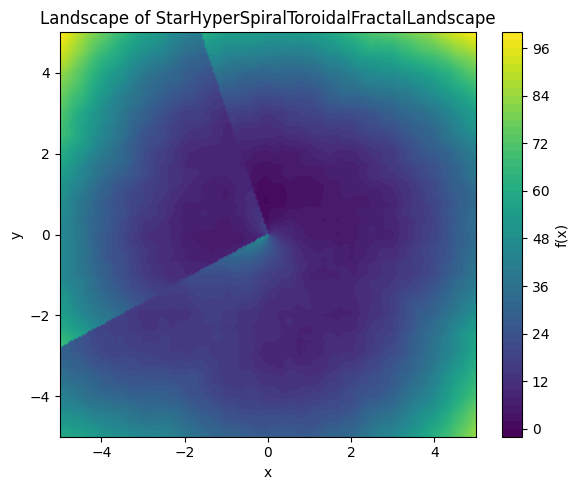

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_landscape(row, bounds=(-5, 5), res=200):
    """
    row  : one row of the dataframe (df.loc[idx] or df.iloc[idx])
    bounds: (low, high) tuple applied to both axes
    res   : grid resolution per axis
    """
    # Re-create the callable from the code string
    ns = {}
    exec(row["code"], ns)                      # defines class with same name as row["name"]
    f   = getattr(ns[row["name"]](dim=2), "f")      # instantiate & grab its .f method

    # Grid
    x = np.linspace(bounds[0], bounds[1], res)
    y = np.linspace(bounds[0], bounds[1], res)
    X, Y = np.meshgrid(x, y)
    pts   = np.stack([X.ravel(), Y.ravel()], axis=1)
    Z     = np.apply_along_axis(f, 1, pts).reshape(X.shape)   # robust fallback

    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    cs = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Landscape of {row['name']}")
    plt.colorbar(cs, ax=ax, label="f(x)")
    plt.tight_layout()
    return fig, ax

# Example usage:
top10 = df.nlargest(10, "fitness").reset_index(drop=True)
for idx in range(len(top10)):
    fig, ax = plot_landscape(top10.iloc[idx], bounds=(-5, 5))
    plt.tight_layout()
    plt.savefig(f"exp2/exp2_landscape_{idx}.png")  # Save each plot
    #plt.show()  # Show each plot one by one


In [ ]:
# --- helper that draws on an existing axis instead of creating a new figure
def _plot_on_ax(row, ax, bounds=(-5, 5), res=150):
    ns = {}
    exec(row["code"], ns)
    f = getattr(ns[row["name"]](dim=2), "f")

    x = np.linspace(*bounds, res)
    y = np.linspace(*bounds, res)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(f, 1, np.stack([X.ravel(), Y.ravel()], axis=1)).reshape(X.shape)

    ax.contourf(X, Y, Z, levels=80, cmap="viridis")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"score: {row['fitness']:.2g}", fontsize=7)

top64 = df.nlargest(64, "fitness").reset_index(drop=True)

rows, cols = 8, 8
fig, axes = plt.subplots(rows, cols, figsize=(14, 14), dpi=300)

for ax in axes.ravel():
    ax.axis("off")           # blank everything first

for ax, (_, row) in zip(axes.ravel(), top64.iterrows()):
    _plot_on_ax(row, ax, bounds=(-5, 5), res=200)

plt.tight_layout()